In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2020-02-19 10:53:13--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2020-02-19 10:53:13--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  22.4MB/s    in 2m 18s  

2020-02-19 10:55:32 (24.4 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import  os,shutil
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [0]:
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png  
  infl

In [0]:
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
#from matplotlib.pyplot import imread

In [0]:
def load_data(directory, ext):

    files = load_data_from_dirs(load_path(directory), ext)
    return files
def load_data_from_dirs_resize(dirs, ext, size):
    files = []
    file_names = []
    count = 0
    for d in dirs:
        for f in os.listdir(d): 
            if f.endswith(ext):
                files.append(resize(io.imread(os.path.join(d,f)), size))
                file_names.append(os.path.join(d,f))
                count = count + 1
    return files
def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    for d in dirs:
        for f in os.listdir(d): 
            if f.endswith(ext):
                image = io.imread(os.path.join(d,f))
                if len(image.shape) > 2:
                    files.append(image)
                    file_names.append(os.path.join(d,f))
                count = count + 1
    print(count)
    return files     
def load_path(path):
    directories = []
    if os.path.isdir(path):
        directories.append(path)
    for elem in os.listdir(path):
        if os.path.isdir(os.path.join(path,elem)):
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    return directories


In [0]:
files = load_data('/content/train_data/DIV2K_train_HR','.png')

800


In [0]:
x_train = files[:500]
x_test = files[600:900]
print(len(x_test),len(x_train))

200 500


In [0]:
np.random.seed(10)
image_shape = (384,384,3)

In [0]:
#from skimage.transform import resize as imresize
#from scipy.misc import imresize
import PIL

In [0]:
def hr_images(images):
    images_hr = array(images)
    return images_hr

def lr_images(images_real , downscale):
    
    images = []
    for img in  range(len(images_real)):
        #images.append(imresize(images_real[img], [images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale], interp='bicubic', mode=None))
        images.append(np.array(PIL.Image.fromarray(images_real[img]).resize([images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale],resample=PIL.Image.BICUBIC)))
    images_lr = array(images)
    return images_lr

def preprocess_HR(x):
    return np.divide(x.astype(np.float32), 127.5) - np.ones_like(x,dtype=np.float32)


def deprocess_HR(x):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8) 


def preprocess_LR(x):
    return np.divide(x.astype(np.float32), 255.)


def deprocess_LR(x):
    x = np.clip(x*255, 0, 255)
    return x

def normalize(input_data):

    return (input_data - 127.5)/127.5 
    
def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8) 

def deprocess_LRS(x):
    x = np.clip(x*255, 0, 255)
    return x.astype(np.uint8)


In [0]:
x_train_hr = hr_images(x_train)
x_train_hr = normalize(x_train_hr)

In [0]:
x_train_hr = hr_images(x_train)
#x_train_hr = normalize(x_train_hr)

x_train_lr = lr_images(x_train, 4)
x_train_lr = normalize(x_train_lr)


x_test_hr = hr_images(x_test)
x_test_hr = normalize(x_test_hr)

x_test_lr = lr_images(x_test, 4)
x_test_lr = normalize(x_test_lr)

print("data processed")

data processed


In [0]:
def plot_generated_images(epoch,generator, examples=3 , dim=(1, 3), figsize=(15, 5)):
    
    rand_nums = np.random.randint(0, x_test_hr.shape[0], size=examples)
    image_batch_hr = (x_test_hr[rand_nums])
    image_batch_lr = x_test_lr[rand_nums]
    gen_img = generator.predict(image_batch_lr)
    generated_image = (gen_img)
    image_batch_lr = (image_batch_lr)
    
    #generated_image = deprocess_HR(generator.predict(image_batch_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[1], interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[1], interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[1], interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('output/gan_generated_image_epoch_%d.png' % epoch)

In [0]:
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add


# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model
    
    
def up_sampling_block(model, kernal_size, filters, strides):
    
    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model


def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Generator(object):

    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape

    def generator(self):
        
	    gen_input = Input(shape = self.noise_shape)
	    
	    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
	    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
	    
	    gen_model = model
        
        # Using 16 Residual Blocks
	    for index in range(16):
	        model = res_block_gen(model, 3, 64, 1)
	    
	    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
	    model = BatchNormalization(momentum = 0.5)(model)
	    model = add([gen_model, model])
	    
	    # Using 2 UpSampling Blocks
	    for index in range(2):
	        model = up_sampling_block(model, 3, 256, 1)
	    
	    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
	    model = Activation('tanh')(model)
	   
	    generator_model = Model(inputs = gen_input, outputs = model)
        
	    return generator_model

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model

In [0]:
def vgg_loss(y_true, y_pred):
    
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [0]:
def train(epochs=1, batch_size=128):

    downscale_factor = 4
    
    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()

    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    generator.compile(loss=vgg_loss, optimizer=adam)
    discriminator.compile(loss="binary_crossentropy", optimizer=adam)
    
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, 3)
    gan = get_gan_network(discriminator, shape, generator, adam)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batch_count):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            #d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
        print("Loss HR , Loss LR, Loss GAN")
        print(d_loss_real, d_loss_fake, loss_gan)

        if e == 1 or e % 5 == 0:
            plot_generated_images(e, generator)
        if e % 300 == 0:
            generator.save('./output/gen_model%d.h5' % e)
            discriminator.save('./output/dis_model%d.h5' % e)
            gan.save('./output/gan_model%d.h5' % e)

In [0]:
train(20000,4)

In [0]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [0]:
os.listdir()

['.config',
 'drive',
 'DIV2K_train_HR.zip',
 'train_data',
 '.ipynb_checkpoints',
 'sample_data']

In [0]:
img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = cv2.imread(i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_crop = crop_center(img,256,256)
    img_list.append(img_crop)
    img_low_list.append(cv2.resize(img_crop,(64,64)))

high_reso_imgs = np.array(img_list)
low_reso_imgs = np.array(img_low_list)

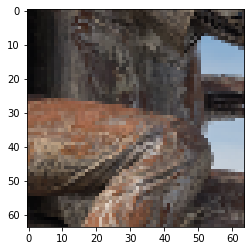

In [0]:
plt.imshow(low_reso_imgs[0])

In [0]:
low_reso_img[1].shape

(64, 64, 3)

#For input LR image

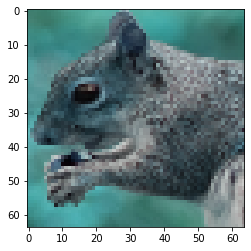

In [0]:
img1 = cv2.imread('/content/demo/0810x4-crop.png')
#img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_low_input_list=[]
img_low_input_list.append(cv2.resize(img1,(64,64)))
img2=np.array(img_low_input_list)
plt.imshow(img2[0])

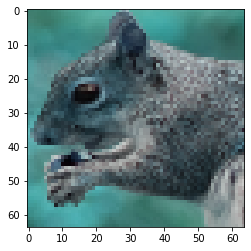

In [0]:
img3=np.array(img_low_input_list)
plt.imshow(img2[0])

In [0]:
img2[0].shape

(64, 64, 3)

#input LR preprocessing completed

In [0]:
high_reso_imgs[4].shape

(256, 256, 3)

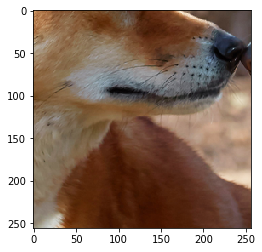

In [0]:
plt.imshow(high_reso_imgs[4])

In [0]:
os.chdir('/content')

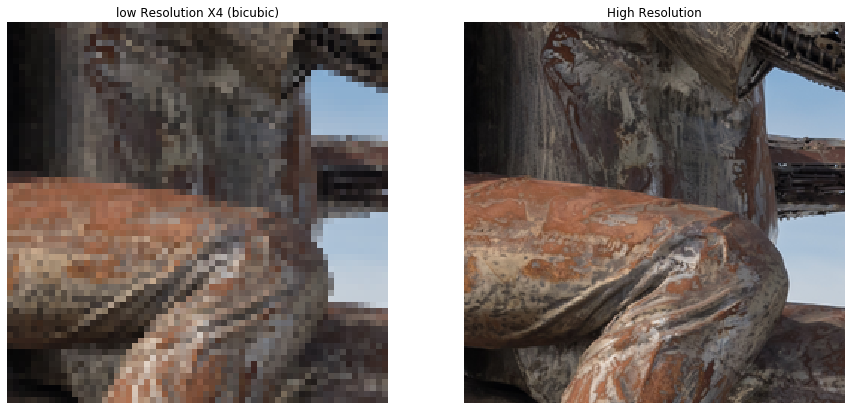

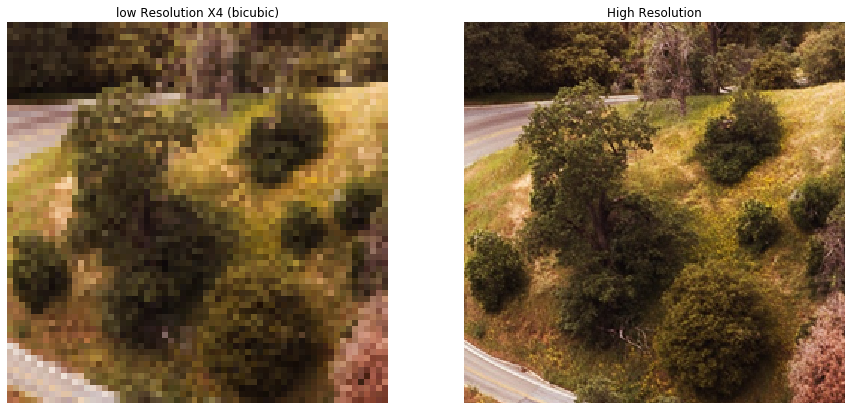

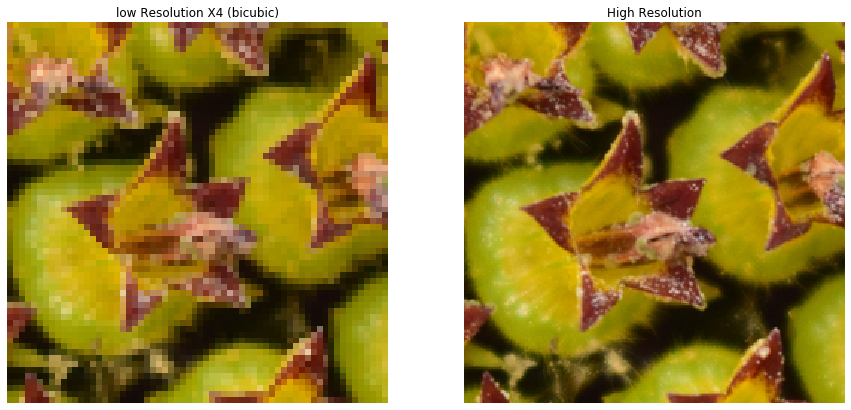

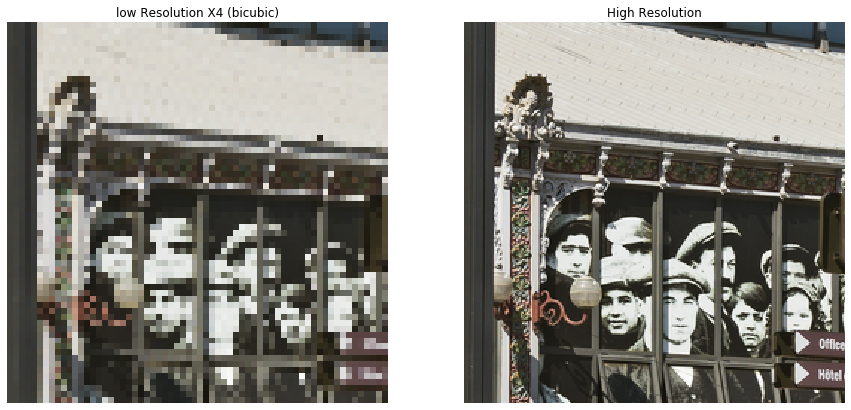

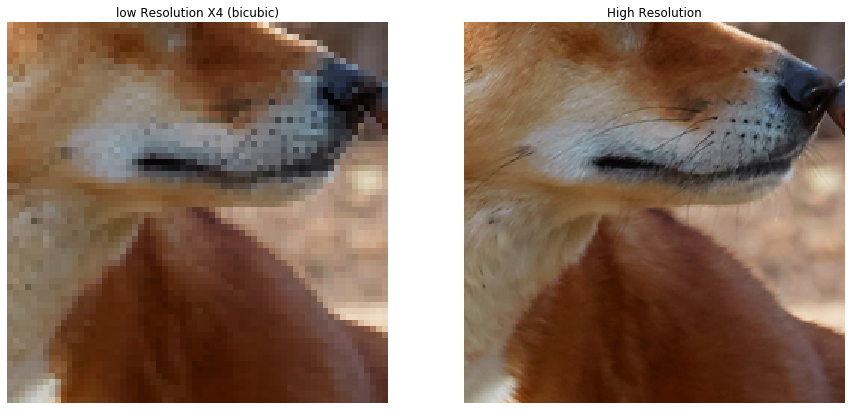

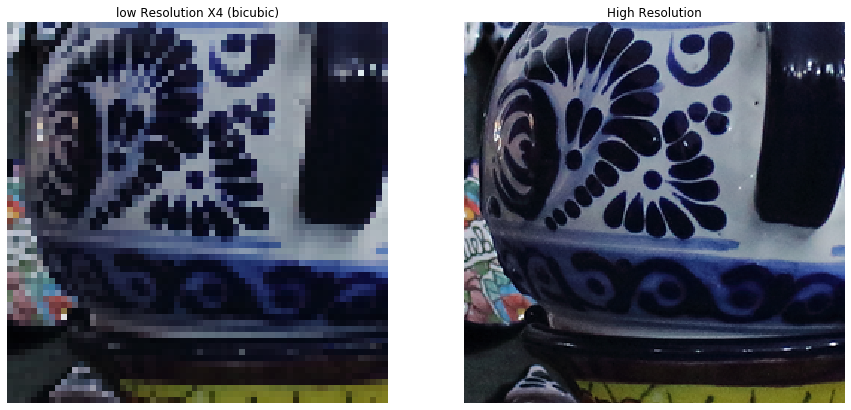

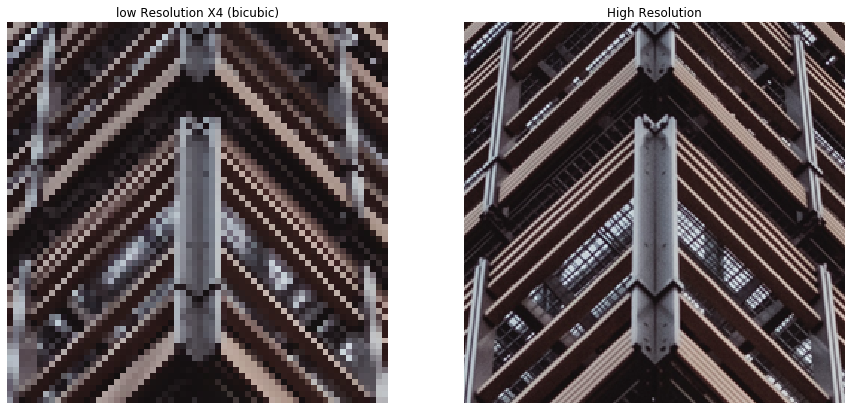

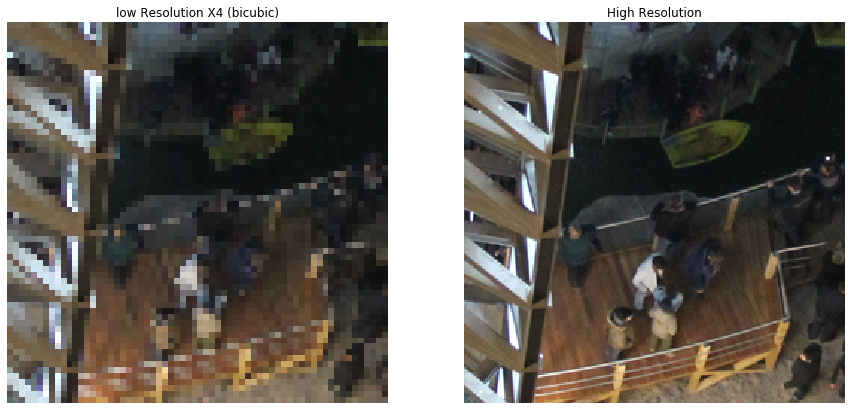

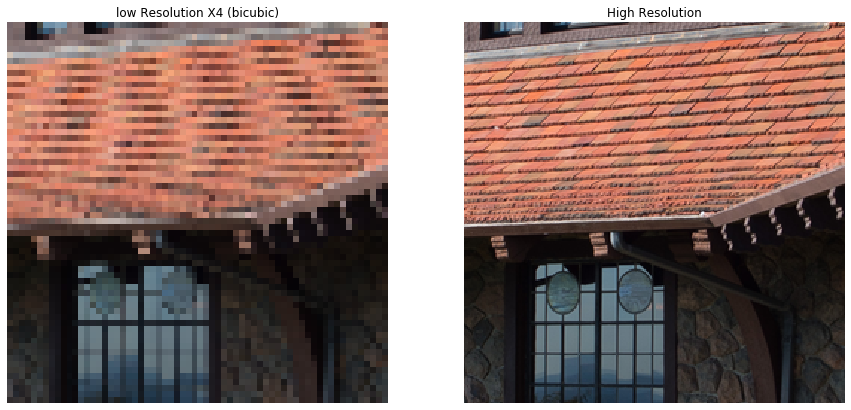

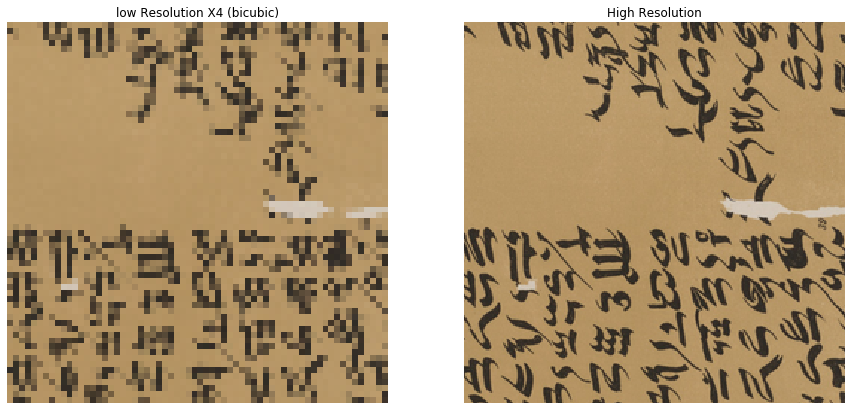

In [0]:
for i in range(10):
  plt.figure(figsize = (15,15))
  plt.subplot(1,2,2)
  plt.imshow(high_reso_imgs[i])
  plt.grid('off')
  plt.axis('off')
  plt.title('High Resolution')
  plt.subplot(1,2,1)
  plt.imshow(cv2.resize(low_reso_imgs[i],(64,64),
                      interpolation = cv2.INTER_CUBIC))
  plt.grid('off')
  plt.axis('off')
  _=plt.title('low Resolution X4 (bicubic)')

In [0]:
class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 64,lr_width = 64,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            
            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)
            
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            
            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):
        vgg = VGG19(weights = "imagenet")
#         vgg.summary()
        vgg.outputs = [vgg.layers[9].output]
        img = Input(shape = self.shape_high_reso)
        img_features = vgg(img)
        vgg_model = Model(img, img_features)
#         for layer in vgg_model.layers:
#             layer.trainable = False
        vgg_model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),
                         metrics =['acc'])
        return vgg_model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.depth_to_space(x, scale))
  
    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)
        
        output_residual = BatchNormalization(momentum=0.8)(output_residual)
        
        output_residual = Add()([output_residual,first_layer])
               
        upsample_layer = self.Upsample_Block(output_residual)
        
        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)
            
        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks, 
                                             n_filters = (i+1)*2*n_filters)
        
        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)


        gan_model = Model(inputs = [gen_input, dis_input], 
                          outputs = [generator_valid, generated_features])
        
        for l in gan_model.layers[-1].layers[-1].layers:
          l.trainable=False
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        
        return gan_model



    def train(self, epochs, save_interval = 100, batch_size = 16):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            if epo % save_interval == 0:
              self.save_GAN_Model(epo)
              self.plotLosses(dlosses,glosses,epo)
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])

In [0]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
        
        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
        
    plt.savefig('predicted.png')

In [0]:
#indx_low1 = np.random.randint(0,low_reso_imgs.shape[0]-1,16)
#norm_img2 = img2[0]/127.5 -1

#Applying the model for input LR Image

In [0]:
generated_hr_img1 = model_srgan.generator.predict(np.expand_dims(img2[0], axis = 0) / 127.5 - 1)

Text(0.5, 1.0, 'SRGAN')

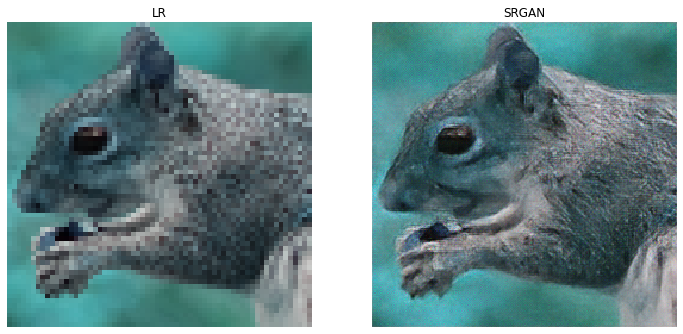

In [0]:
plt.figure(figsize = (12,12))
plt.subplot(1,2,1)
#plt.imshow(cv2.resize(img3[0],(256,256),interpolation = cv2.INTER_CUBIC))
plt.imshow(img3[0])
plt.grid('off')
plt.axis('off')
plt.title('LR')

plt.subplot(1,2,2)
img_unnorm1 = (generated_hr_img1+1) * 127.5
plt.imshow(np.squeeze(img_unnorm1, axis = 0).astype(np.uint8))
plt.grid('off')
plt.axis('off')
plt.title('SRGAN')

#Generated SR for given input LR
#completed

In [0]:
model_srgan = SRGAN()





574717952/574710816 [==============================] - 8s 0us/step










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  11252995    input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    3759681     model_3[1][0]                    
__________________________________________________________________________________________________
model_1 (Model) 

In [0]:
model_srgan.generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, 64, 64)   262144      conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

In [0]:
model_srgan.discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     7385

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
#model_srgan.train(500, save_interval=20 ,batch_size=16)

In [0]:
 os.chdir('/content')
!mkdir training_process
os.chdir('/content/training_process')

In [0]:
curr_path=os.getcwd()
curr_path
shutil.move('/content/srgan_weights_epoch_100.h5', curr_path)

'/content/training_process/srgan_weights_epoch_100.h5'

In [0]:
#model_srgan.srgan.load_weights('srgan_weights_epoch_240.h5')

In [0]:
model_srgan.srgan.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')

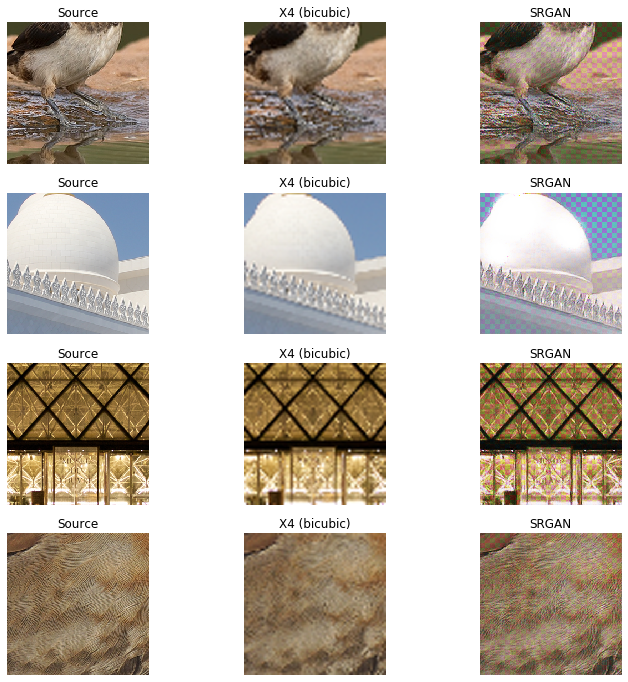

In [0]:
# Load pretrained model
model_srgan.srgan.load_weights('srgan_weights_epoch_100.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)